##  This notebook is for the datasets with detailed job description.
Every night at 1am
Scrape data from Indeed to create 4 csv datasets based on:
'data science' 
'data analyst'
'machine learning'
'artifical intelligence'

In [25]:
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt
# Add project path
parent_project_path = os.path.abspath(os.path.join('..'))
if parent_project_path not in sys.path:
    sys.path.append(parent_project_path)
from src.library.sb_utils import save_file

today = datetime.today().strftime('%Y_%m_%d')
dfNames=['da','ds','ml','ai']

list_of_df = []
data = pd.DataFrame()


for n in dfNames:
    fileName = '../data/raw/{0}_last{1}d_RC_{2}.csv'.format(n,'1', today)
    df = pd.read_csv(fileName, skiprows=[0])
    print(df.shape)
    
    #will be deleted after first couple of trials
    list_of_df.append(df)
    
    #combine 3 files together
    data = data.append(df, ignore_index=True)
    print(data.shape)


(62, 16)
(62, 16)
(179, 16)
(241, 16)
(209, 16)
(450, 16)
(48, 16)
(498, 16)


In [26]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 498 entries, 0 to 497
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   JobID            498 non-null    object 
 1   JobTitle         498 non-null    object 
 2   Company          498 non-null    object 
 3   Location         498 non-null    object 
 4   CompanyRating    405 non-null    float64
 5   CompanyUrl       405 non-null    object 
 6   CompanyIndustry  388 non-null    object 
 7   CompanySize      388 non-null    object 
 8   PostDate         498 non-null    object 
 9   ExtractDate      498 non-null    object 
 10  Summary          498 non-null    object 
 11  Salary           36 non-null     object 
 12  Remote           50 non-null     object 
 13  JobUrl           498 non-null    object 
 14  JobDetail        23 non-null     object 
 15  JobDescription   57 non-null     object 
dtypes: float64(1), object(15)
memory usage: 62.4+ KB


In [27]:
# To confirm the necessity of the step of de-duping the combined daily file. 
id_0 = set(list_of_df[0].JobID)
id_1 = set(list_of_df[1].JobID)
id_2 = set(list_of_df[2].JobID)
id_3 = set(list_of_df[3].JobID)

In [28]:
print(len(id_0.intersection(id_1)))
print(len(id_0.intersection(id_2)))
print(len(id_0.intersection(id_3)))
print(len(id_1.intersection(id_2)))
print(len(id_1.intersection(id_3)))
print(len(id_2.intersection(id_3)))

3
2
0
58
11
21


### Step 2: De - duplicate records with same JobID
There are overlaps betweem 4 datasets


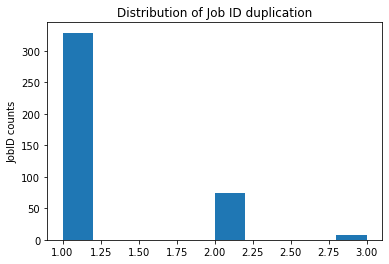

In [29]:
data.JobID.value_counts().plot(kind='hist')
plt.title('Distribution of Job ID duplication')
plt.ylabel('JobID counts')
plt.xlabel('')
plt.show()

In [30]:
#Group by column having count > 1 
#data.groupby('JobID').filter(lambda x: len(x) >1 ).sort_values('JobID')

In [31]:
data.JobID.describe()

count                  498
unique                 410
top       d7b5cec7be2aa3dc
freq                     3
Name: JobID, dtype: object

In [32]:
data.duplicated(subset ='JobID').sum()

88

In [33]:
# To de-dup the records in the combined file
data.drop_duplicates(subset = 'JobID', inplace= True)
data.JobID.describe()

count                  410
unique                 410
top       8a3287e5db433f20
freq                     1
Name: JobID, dtype: object

In [34]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 410 entries, 0 to 497
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   JobID            410 non-null    object 
 1   JobTitle         410 non-null    object 
 2   Company          410 non-null    object 
 3   Location         410 non-null    object 
 4   CompanyRating    331 non-null    float64
 5   CompanyUrl       331 non-null    object 
 6   CompanyIndustry  314 non-null    object 
 7   CompanySize      315 non-null    object 
 8   PostDate         410 non-null    object 
 9   ExtractDate      410 non-null    object 
 10  Summary          410 non-null    object 
 11  Salary           33 non-null     object 
 12  Remote           45 non-null     object 
 13  JobUrl           410 non-null    object 
 14  JobDetail        22 non-null     object 
 15  JobDescription   51 non-null     object 
dtypes: float64(1), object(15)
memory usage: 54.5+ KB


In [35]:
# To reindex 
data.index = np.arange(0,len(data))

### Step 3: Create a new variable 'DatePosted' as the exact date of job posted

In [36]:
data.PostDate.unique()

array(['Just posted', 'Today', '1 day ago'], dtype=object)

In [37]:
data.PostDate.str.contains('ago').sum()

38

In [38]:
'|'.join(['ago','day','days'])

'ago|day|days'

In [39]:
# To create a new variable 'DatePosted' by remove the string from 'PostDate' and convert to int
data['DatePosted'] = data.PostDate.str.replace('day ago|days ago','').str.replace('Today|Just posted','0').str.strip().astype(int)

In [40]:
data.DatePosted.unique()

array([0, 1])

In [41]:
data.DatePosted.dtypes

dtype('int32')

In [42]:
# To convert 'ExtractDate' to datetime type
data['ExtractDate'] = pd.to_datetime(data['ExtractDate'])

In [43]:
# To Convert 'DatePosted' from int to timeDelta type and compute the exact date when the job was posted 
data.DatePosted = pd.to_timedelta(data.DatePosted, unit='D')
data.DatePosted = pd.to_datetime(data['ExtractDate'] - data['DatePosted'])


In [44]:
data.loc[:,['PostDate','ExtractDate','DatePosted']]

,PostDate,ExtractDate,DatePosted
0,Just posted,2021-03-01,2021-03-01
1,Today,2021-03-01,2021-03-01
2,Today,2021-03-01,2021-03-01
3,Today,2021-03-01,2021-03-01
4,Today,2021-03-01,2021-03-01
...,...,...,...
405,Today,2021-03-01,2021-03-01
406,Today,2021-03-01,2021-03-01
407,1 day ago,2021-03-01,2021-02-28
408,Today,2021-03-01,2021-03-01


### Step 4: Create a new variable 'isRemote' and assign boolean value based on varible 'Remote' OR 'Location'

In [45]:
data.Remote.unique()

array([nan, 'Temporarily remote', 'Remote'], dtype=object)

In [46]:
data.Remote.describe()

count         45
unique         2
top       Remote
freq          36
Name: Remote, dtype: object

In [47]:
# Work on the contingency table (pivot talbe) between Location and Remote
s_Location = data.Location.copy()
s_Location[s_Location != 'Remote'] = 'Others'
s_Location.describe()

count        410
unique         2
top       Others
freq         395
Name: Location, dtype: object

In [48]:
s_Remote = data.Remote.copy()
s_Remote[s_Remote != 'Remote'] = 'Others'
s_Remote.describe()

pd.crosstab(s_Location, s_Remote)

Remote,Others,Remote
Location,,
Others,359,36
Remote,15,0


In [49]:
data.Remote.unique()

array([nan, 'Temporarily remote', 'Remote'], dtype=object)

In [50]:
# try to construct contingency table directly from dataframe using groupby
#[('Others' if (l!='Remote') else l, 'Others' if (r!='Remote') else r )   for l,r in data['Location','Remote']]  #.groupby(by =['Location', 'Remote']).agg('count')

In [51]:
data.Location.str.contains('Remote').sum()

15

In [52]:
(data.Location =='Remote').sum()

15

In [53]:
# To assign the value of Remote to the variable 'Remote' if the value of location is 'Remote'
# It maynot be necessary since we not going to use varialbe 'Remote' later
#data.loc[data.Location.str.contains('Remote'),'Remote'] = 'Remote'

In [54]:
# To create a new boolean variable 'isRemote' and assign Ture if varible 'Remote' OR 'Location' is Remote
data['isRemote'] = (data.Remote == 'Remote') | (data.Location =='Remote')
data.isRemote.describe()

count       410
unique        2
top       False
freq        359
Name: isRemote, dtype: object

### Step 5: Extract city, state information from Location, Create new variables 'City', ‘State', and 'Region' 


In [55]:
data.Location.describe()

count              410
unique             129
top       New York, NY
freq                46
Name: Location, dtype: object

In [56]:
# To create two new variables City and State
newDf = data.Location.str.split(pat =',',expand =True)
data['City'] = newDf[0]
data['State'] = newDf[1]

In [57]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 410 entries, 0 to 409
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   JobID            410 non-null    object        
 1   JobTitle         410 non-null    object        
 2   Company          410 non-null    object        
 3   Location         410 non-null    object        
 4   CompanyRating    331 non-null    float64       
 5   CompanyUrl       331 non-null    object        
 6   CompanyIndustry  314 non-null    object        
 7   CompanySize      315 non-null    object        
 8   PostDate         410 non-null    object        
 9   ExtractDate      410 non-null    datetime64[ns]
 10  Summary          410 non-null    object        
 11  Salary           33 non-null     object        
 12  Remote           45 non-null     object        
 13  JobUrl           410 non-null    object        
 14  JobDetail        22 non-null     object   

In [58]:
# To clean up values of City ???? whether to treat special case 'United States' as Remote as well????
data.loc[data.City == 'Remote', 'City'] = np.nan
data.loc[data.City == 'United States', 'City'] = np.nan

In [59]:
assert data.City.str.contains('Remote|United States').any()  == False

In [60]:
us_state_abbrev = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'American Samoa': 'AS',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'District of Columbia': 'DC',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Guam': 'GU',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Northern Mariana Islands':'MP',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Puerto Rico': 'PR',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virgin Islands': 'VI',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY'
}

In [61]:
data.loc[((data.State.isnull()) & (~data.City.isnull())), 'City']


69           Florida
103         Illinois
169       California
179            Texas
204         Illinois
209          Florida
250    Massachusetts
253       New Jersey
260            Texas
296       California
316       California
Name: City, dtype: object

In [62]:
# To fill the missing value of 'State' from 'City' for those which has only location of State 
data.State.fillna(data.City, inplace=True)

In [63]:
# To clean up values in 'City'
data.loc[data.State == data.City, 'City'] = np.nan

In [64]:
data.State.unique()

array([' NJ', ' NY', ' RI', ' MD', nan, ' CO', ' GA', ' TX', ' CT', ' VA',
       ' PA', ' CA', ' DC', ' KY', ' IN', ' MO', ' IL', ' OH', ' MI',
       ' NC', ' AZ', ' AK', ' WI', ' DE', ' MN', ' IA', ' MA', ' NE',
       ' NV', 'Florida', ' WA', 'Illinois', ' HI', ' FL', ' OR',
       'California', 'Texas', ' NM', 'Massachusetts', 'New Jersey', ' UT'],
      dtype=object)

In [65]:
# To extract State abbrevation value from City variables to fill those missing values into 'State'
data.loc[data.State.str.len() >3,'State']=data.loc[data.State.str.len() >3,'State'].str.replace(' State','').map(us_state_abbrev)



In [66]:
# To clean up the State values
data.State= data.State.str.strip()

In [67]:
data.loc[:,['Location','City','State']]

,Location,City,State
0,"New Brunswick, NJ",New Brunswick,NJ
1,"New York, NY",New York,NY
2,"Johnston, RI",Johnston,RI
3,"New York, NY",New York,NY
4,"New York, NY",New York,NY
...,...,...,...
405,"Austin, TX",Austin,TX
406,"Hanover, MD",Hanover,MD
407,"Santa Clara, CA",Santa Clara,CA
408,"Vail, AZ",Vail,AZ


In [68]:
# To cleaning up the value of 'Washington DC' on variable 'City'
data.loc[(data.City == 'Washington') & (data.State == 'DC'), 'City'] ='DC'

In [69]:
# special cases "New York, NY"
data.loc[data.City.isin(us_state_abbrev.keys()), ['Location','City','State']]

,Location,City,State
1,"New York, NY",New York,NY
3,"New York, NY",New York,NY
4,"New York, NY",New York,NY
22,"New York, NY",New York,NY
34,"New York, NY",New York,NY
44,"New York, NY",New York,NY
73,"New York, NY",New York,NY
75,"New York, NY",New York,NY
76,"New York, NY",New York,NY
78,"New York, NY",New York,NY


In [70]:
data.State.unique()

array(['NJ', 'NY', 'RI', 'MD', nan, 'CO', 'GA', 'TX', 'CT', 'VA', 'PA',
       'CA', 'DC', 'KY', 'IN', 'MO', 'IL', 'OH', 'MI', 'NC', 'AZ', 'AK',
       'WI', 'DE', 'MN', 'IA', 'MA', 'NE', 'NV', 'FL', 'WA', 'HI', 'OR',
       'NM', 'UT'], dtype=object)

In [71]:
# To categorize state value into 4 regions 
us_state_regions = {
    'Alabama': 'South',
    'Alaska': 'West',
    'American Samoa': 'Islands',
    'Arizona': 'West',
    'Arkansas': 'South',
    'California': 'West',
    'Colorado': 'West',
    'Connecticut': 'Northeast',
    'Delaware': 'South',
    'District of Columbia': 'South',
    'Florida': 'South',
    'Georgia': 'South',
    'Guam': 'Islands',
    'Hawaii': 'West',
    'Idaho': 'West',
    'Illinois': 'Midwest',
    'Indiana': 'Midwest',
    'Iowa': 'Midwest',
    'Kansas': 'Midwest',
    'Kentucky': 'South',
    'Louisiana': 'South',
    'Maine': 'Northeast',
    'Maryland': 'South',
    'Massachusetts': 'Northeast',
    'Michigan': 'Midwest',
    'Minnesota': 'Midwest',
    'Mississippi': 'South',
    'Missouri': 'Midwest',
    'Montana': 'West',
    'Nebraska': 'Midwest',
    'Nevada': 'West',
    'New Hampshire': 'Northeast',
    'New Jersey': 'Northeast',
    'New Mexico': 'West',
    'New York': 'Northeast',
    'North Carolina': 'South',
    'North Dakota': 'Midwest',
    'Northern Mariana Islands':'Islands',
    'Ohio': 'Midwest',
    'Oklahoma': 'South',
    'Oregon': 'West',
    'Pennsylvania': 'Northeast',
    'Puerto Rico': 'Islands',
    'Rhode Island': 'Northeast',
    'South Carolina': 'South',
    'South Dakota': 'Midwest',
    'Tennessee': 'South',
    'Texas': 'South',
    'Utah': 'West',
    'Vermont': 'Northeast',
    'Virgin Islands': 'Islands',
    'Virginia': 'South',
    'Washington': 'West',
    'West Virginia': 'South',
    'Wisconsin': 'Midwest',
    'Wyoming': 'West'
}

In [72]:
us_state_regions_mapping =  {v: us_state_regions[k] for k, v in us_state_abbrev.items()}

In [73]:
# To create a new variable 'Region' by mapping to the dict
data['Region'] = data.loc[~data.State.isnull(),'State'].map(us_state_regions_mapping).astype('category')

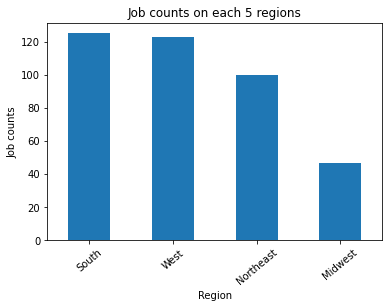

In [74]:
data.Region.value_counts().plot(kind='bar')
plt.ylabel('Job counts')
plt.xlabel('Region')
plt.xticks(rotation=40)
plt.title('Job counts on each 5 regions')
plt.show()

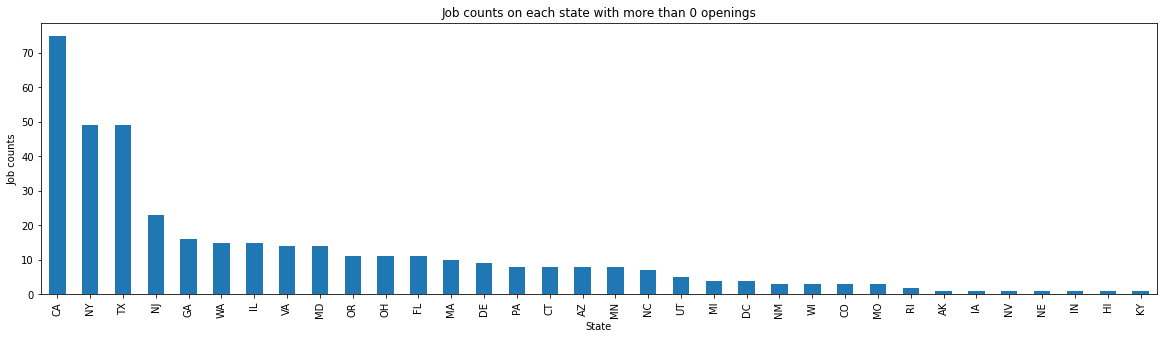

In [75]:
plt.subplots(figsize=(20, 5))
data.State.value_counts().plot(kind='bar')
plt.ylabel('Job counts')
plt.xlabel('State')
plt.title('Job counts on each state with more than 0 openings')
plt.show()

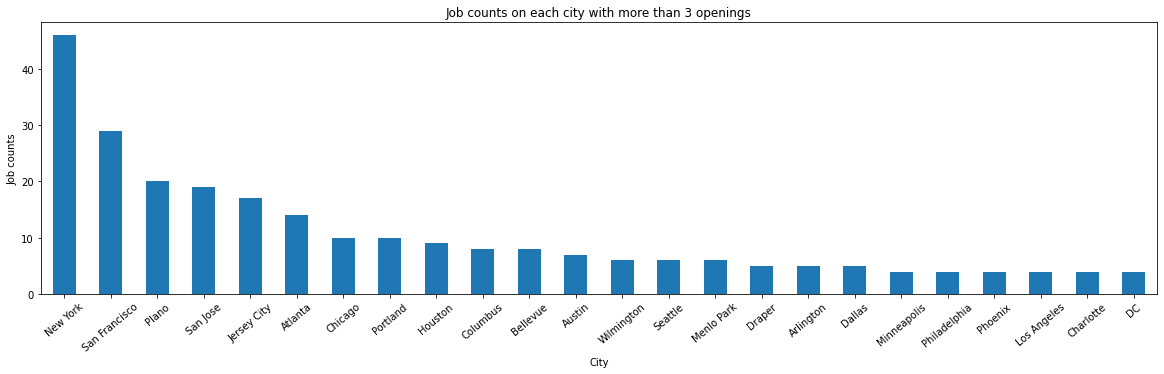

In [76]:
plt.subplots(figsize=(20, 5))
data.groupby('City').filter(lambda x: len(x) >3 )['City'].value_counts().plot(kind='bar')
plt.xticks(rotation=40)
plt.ylabel('Job counts')
plt.xlabel('City')
plt.title('Job counts on each city with more than 3 openings')
plt.show()     

In [77]:
data.City.str.contains('Princeton').sum()

0

### Step 6: Create new variables 'isSenior', 'isJunior', and 'isMid' from job Title

In [78]:
data.JobTitle.unique()

array(['Data Analyst', 'Loan IQ Data Analyst', 'HR Data Analyst',
       'Financial Data Analyst - Loan IQ Experience',
       'Experienced Data Analyst - Loan IQ', 'Data Analyst Intern',
       'Junior Data Analyst', 'Data Analyst (Forecasting)',
       'Financial Performance Data Analyst', 'Data Analyst - Remote - PT',
       'Data Analyst I - Controlled Substance Auditor',
       'Clinical Data Analytic Coordinator', 'DATA ANALYST (FORECASTING)',
       'Financial Data Analyst II (Healthcare Reimbursement)',
       'Data Lake Reporting Analyst', 'Senior Product Data Analyst- PIM',
       'Senior Data Analyst (Talent)', 'Sr. Business Data Analyst',
       'Sr. Business and Data Analyst',
       'Senior Medicaid Reporting and Data Analyst',
       'Data Architect/AWS builder with Python experience needed',
       'Senior Data Analyst', 'Senior Data Analyst, Operations',
       'Data Specialist',
       'Electronic Data Interchange (EDI) Data Analyst',
       'Safety and Security Data 

In [79]:
# these may not be necessary
#data['JobTitle'] = data['JobTitle'].astype('str')
#type(data.JobTitle[0])

In [80]:
data['isSenior'] = data.JobTitle.str.contains('Senior|Sr|sr|Director|VP|Lead|Principal')

In [81]:
data['isJunior'] = data.JobTitle.str.contains('Junior|Jr|jr|Intern')

In [82]:
data['isMid'] = data.JobTitle.str.contains('Mid Level|Mid-')

In [83]:
data.loc[:, ['JobTitle','isSenior','isJunior','isMid']].head(3)

,JobTitle,isSenior,isJunior,isMid
0,Data Analyst,False,False,False
1,Loan IQ Data Analyst,False,False,False
2,HR Data Analyst,False,False,False


In [84]:
data[data.JobTitle.str.contains('Mid Level|Mid-')]

,JobID,JobTitle,Company,Location,CompanyRating,CompanyUrl,CompanyIndustry,CompanySize,PostDate,ExtractDate,...,JobDetail,JobDescription,DatePosted,isRemote,City,State,Region,isSenior,isJunior,isMid
271,70d25603189f4587,Business Information Architect (Mid-Level) - 1...,USAA,"Tampa, FL",3.9,https://www.indeed.com/cmp/Usaa,Insurance,"more than 10,000",Today,2021-03-01,...,NaN,Purpose of Job This role would work with the C...,2021-03-01,True,Tampa,FL,South,False,False,True
382,7816ff1651187614,Business Information Architect (Mid-Level) - 1...,USAA,"Trinity, FL",3.9,https://www.indeed.com/cmp/Usaa,Insurance,"more than 10,000",Today,2021-03-01,...,NaN,Purpose of Job This role would work with the C...,2021-03-01,True,Trinity,FL,South,False,False,True


### Step 7: Process Salary data, and create new variables SalaryMidValue and SalaryGroup 

In [85]:
# string, dict, list appear as Object in df, however, the type can be tested as individual cell
# data.Salary = data.Salary.astype(str) # this cause missing value from NaN to 'nan'
type(data.Salary[0])


float

In [86]:
# the $ that prevents the substring to be found
data.Salary.str.contains('103,690 ').sum()

1

In [87]:
data.loc[(data.Salary =='$103,690 - $134,798 a year') & (data.isRemote), 'JobDescription']#.iloc[0]

Series([], Name: JobDescription, dtype: object)

In [88]:
#data.Salary.unique()

In [89]:
# To create a new variable 'SalaryUnit'
data['SalaryUnit'] = data.Salary.str.extract('(an hour|a year|a month|a week|per class|a day)', expand = True)
data['SalaryUnit'].unique()

array([nan, 'a year', 'an hour', 'a month'], dtype=object)

In [90]:
# using regular expression
data.Salary.str.replace('[^0-9-.]','').unique()

array([nan, '75000-140000', '31775-60684', '45000-70000', '15-21',
       '97840-189457', '36000', '12.98', '52495-72213', '70883-110452',
       '97078-133961', '50000-75000', '60-79', '40-50', '103690-134798',
       '125000', '110000-130000', '109655-142549', '45000-65000',
       '65000-90000', '70-100', '60000-75000', '100000-170000',
       '75000-110000', '50000-65000', '135522-189947', '112125-145760',
       '14-17', '8000'], dtype=object)

In [91]:
data.loc[data.Salary.str.contains('\+') == True]

,JobID,JobTitle,Company,Location,CompanyRating,CompanyUrl,CompanyIndustry,CompanySize,PostDate,ExtractDate,...,JobDescription,DatePosted,isRemote,City,State,Region,isSenior,isJunior,isMid,SalaryUnit


In [92]:
# To create a new variable 'SalaryMidValue' going to contain the mid point value for the arrange of salary
#data['SalaryMidValue'] = data['Salary'].str.replace('an hour|a year|a month|a week|per class|a day','').str.replace('$','').str.replace(',','')

data['SalaryMidValue'] = data.Salary.str.replace('[^0-9-.]','')
data.loc[~data.Salary.isnull(),['Salary','SalaryUnit','SalaryMidValue']].head(4)

,Salary,SalaryUnit,SalaryMidValue
5,"$75,000 - $140,000 a year",a year,75000-140000
6,"$31,775 - $60,684 a year",a year,31775-60684
7,"$45,000 - $70,000 a year",a year,45000-70000
23,$15 - $21 an hour,an hour,15-21


In [93]:
data.columns



Index(['JobID', 'JobTitle', 'Company', 'Location', 'CompanyRating',
       'CompanyUrl', 'CompanyIndustry', 'CompanySize', 'PostDate',
       'ExtractDate', 'Summary', 'Salary', 'Remote', 'JobUrl', 'JobDetail',
       'JobDescription', 'DatePosted', 'isRemote', 'City', 'State', 'Region',
       'isSenior', 'isJunior', 'isMid', 'SalaryUnit', 'SalaryMidValue'],
      dtype='object')

In [95]:
# Set busniss rule to treat range and Ignore 'Up to' and 'From' 
#data['SalaryMidValue'] = data.SalaryMidValue.str.replace('Up to|From','').str.strip()
#data.SalaryMidValue.unique()

In [96]:
# Take mid value for range salary
s_df = data.SalaryMidValue.str.split(pat ='-',expand =True)
s_df[1].fillna(s_df[0], inplace=True)

data['SalaryMidValue']  = (s_df[1].astype(float)+s_df[0].astype(float))/2


In [97]:
data.loc[~data.Salary.isnull(),['Salary','SalaryUnit','SalaryMidValue']].head(4)

,Salary,SalaryUnit,SalaryMidValue
5,"$75,000 - $140,000 a year",a year,107500.0
6,"$31,775 - $60,684 a year",a year,46229.5
7,"$45,000 - $70,000 a year",a year,57500.0
23,$15 - $21 an hour,an hour,18.0


In [98]:
data.loc[data.SalaryMidValue >100000,['Salary','SalaryUnit','SalaryMidValue']].sort_values('SalaryMidValue').tail(10)

,Salary,SalaryUnit,SalaryMidValue
47,"$97,078 - $133,961 a year",a year,115519.5
118,"$103,690 - $134,798 a year",a year,119244.0
188,"$110,000 - $130,000 a year",a year,120000.0
148,"$125,000 a year",a year,125000.0
229,"$109,655 - $142,549 a year",a year,126102.0
389,"$112,125 - $145,760 a year",a year,128942.5
251,"$100,000 - $170,000 a year",a year,135000.0
347,"$100,000 - $170,000 a year",a year,135000.0
25,"$97,840 - $189,457 a year",a year,143648.5
321,"$135,522 - $189,947 a year",a year,162734.5


In [99]:
# Convert hourly rate to Salary based on formula hr * 40 * 52 
data.loc[data.SalaryUnit.str.contains('hour', na=False),'SalaryMidValue'] = data.SalaryMidValue * 40 * 52

In [100]:
# Convert monthly rate to Salary based on formula mr * 12
data.loc[data.SalaryUnit.str.contains('month', na=False),'SalaryMidValue'] = data.SalaryMidValue * 12

In [101]:
# Convert weekly rate to Salary based on fomula wr * 52 
data.loc[data.SalaryUnit.str.contains('week', na = False), 'SalaryMidValue'] =data.SalaryMidValue * 52

In [102]:
# Convert daily rate to Salary based on formula dr * 5 * 52
data.loc[data.SalaryUnit.str.contains('day', na=False),'SalaryMidValue'] = data.SalaryMidValue * 5 * 52

In [103]:
# Ignore the teaching job
data.loc[data.SalaryUnit.str.contains('class', na=False),'SalaryMidValue'] = np.nan

In [104]:
print(data.SalaryMidValue.describe())

count        33.000000
mean      91285.466667
std       40915.410339
min       26998.400000
25%       57500.000000
50%       92500.000000
75%      125000.000000
max      176800.000000
Name: SalaryMidValue, dtype: float64


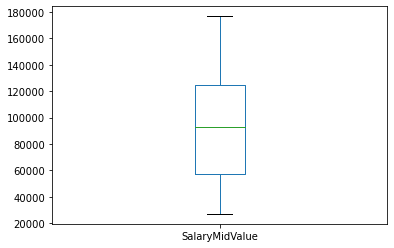

In [139]:
data.SalaryMidValue.plot(kind='box')
plt.show()

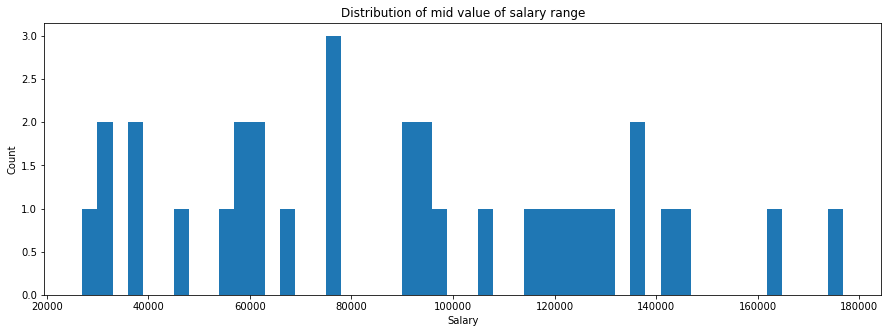

In [105]:
plt.subplots(figsize = (15,5))
data.SalaryMidValue.plot(kind='hist', bins=50)
plt.xlabel('Salary')
plt.ylabel('Count')
plt.title('Distribution of mid value of salary range')
plt.show()

In [106]:
# Create SalaryGroup for SalaryMidValue variable
salaryGroupLabels = ['20K-50K','50K-75k','75k-100k','100k-125k','125k+']
salaryRanges =[20000, 50000, 75000, 100000, 125000, np.inf]
data['SalaryGroup'] = pd.cut(data.SalaryMidValue, bins = salaryRanges, labels = salaryGroupLabels)
#data['SalaryGroup'] = pd.qcut(data.SalaryMidValue, q=5, labels = salaryGroupLabels)
data.loc[~data.Salary.isnull(),['Salary','SalaryUnit','SalaryMidValue','SalaryGroup']].head()

,Salary,SalaryUnit,SalaryMidValue,SalaryGroup
5,"$75,000 - $140,000 a year",a year,107500.0,100k-125k
6,"$31,775 - $60,684 a year",a year,46229.5,20K-50K
7,"$45,000 - $70,000 a year",a year,57500.0,50K-75k
23,$15 - $21 an hour,an hour,37440.0,20K-50K
25,"$97,840 - $189,457 a year",a year,143648.5,125k+


In [107]:
data.SalaryGroup.value_counts().sort_index()

20K-50K      6
50K-75k      6
75k-100k     8
100k-125k    5
125k+        8
Name: SalaryGroup, dtype: int64

In [108]:
((data.SalaryMidValue <= 125000) & (data.SalaryMidValue > 100000)).sum()

5

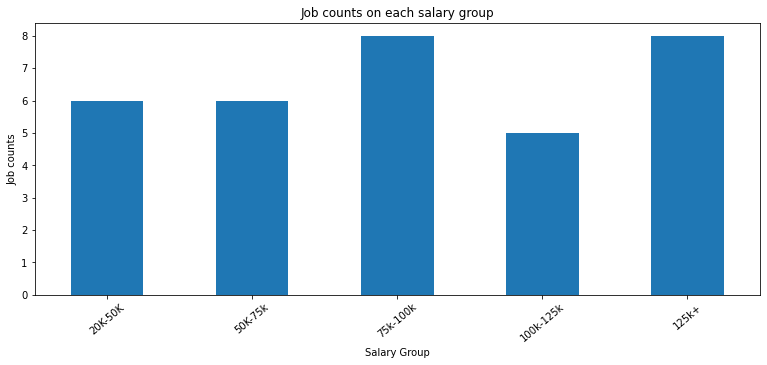

In [109]:
plt.subplots(figsize=(13,5))
data.SalaryGroup.value_counts(sort=False).plot(kind='bar')
plt.xticks(rotation =40)
plt.xlabel('Salary Group')
plt.ylabel('Job counts')
plt.title('Job counts on each salary group')
plt.show()

In [110]:
assert data.SalaryMidValue.min() > 10000  

In [111]:
(data.SalaryMidValue < 100000).sum()

20

In [112]:
data.SalaryMidValue.isnull().sum()

377

In [113]:
data.loc[data.SalaryMidValue > 300000]

,JobID,JobTitle,Company,Location,CompanyRating,CompanyUrl,CompanyIndustry,CompanySize,PostDate,ExtractDate,...,isRemote,City,State,Region,isSenior,isJunior,isMid,SalaryUnit,SalaryMidValue,SalaryGroup


### Step 8:  Create a new varible 'CompanySizeGroup' 


In [148]:
data.CompanySize.unique()

array(['Retail & Wholesale', 'Healthcare', 'Human Resources & Staffing',
       'Education', nan, 'Pharmaceutical & Biotechnology',
       'Manufacturing', 'Consulting and Business Services', 'Insurance',
       'Legal', 'Government & Public Administration',
       'Financial Services', 'Media & Communication',
       'Information Technology', 'Nonprofit & NGO', 'Telecommunications',
       'Management & Consulting', 'Transportation & Logistics',
       'Construction & Facilities Services', 'Agriculture', 'Real Estate',
       'Restaurants & Food Service', 'Beauty & Wellness', 'Wholesale',
       'Health Care', 'Energy, Mining & Utilities', 'Aerospace & Defense',
       'Health Insurance Carriers', 'Computer Hardware Development',
       'Research & Development', 'Personal Consumer Services',
       'Advertising & Public Relations',
       'Construction, Repair & Facilities Services', 'Automotive',
       'Hospitals & Health Clinics', 'Banking & Lending',
       'Video Game Publishing'

In [116]:
companySizeGroup_mapping={'1001 to 5,000':'Large', 'more than 10,000':'Large', '5,001 to 10,000':'Large','501 to 1,000':'Midsize','201 to 500':'Midsize', '51 to 200':'Small',  '11 to 50':'Small'}

In [117]:
data['CompanySizeGroup'] = data.loc[~data.CompanySize.isnull(), 'CompanySize'].map(companySizeGroup_mapping).astype('category')

In [ ]:
data.CompanySizeGroup.uni

IndexError: index 0 is out of bounds for axis 0 with size 0

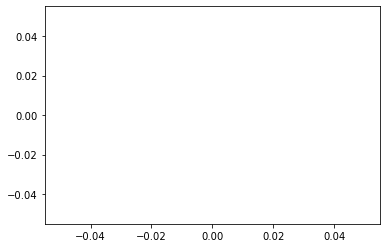

In [147]:
data.CompanySizeGroup.value_counts().plot(kind='barh')
plt.xticks(rotation ='40')
plt.ylabel('Company Size')
plt.xlabel('Job counts')
plt.title('Job counts on size group of company')
plt.show()

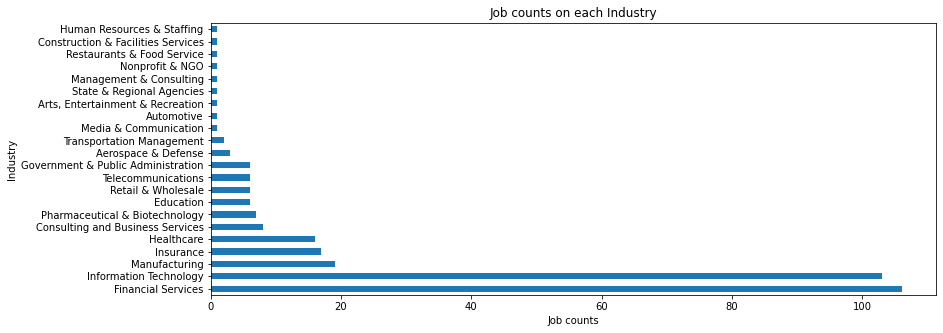

In [143]:
plt.subplots(figsize=(13,5))
data.CompanyIndustry.value_counts().plot(kind='barh')
plt.xlabel('Job counts')
plt.ylabel('Industry')
plt.title('Job counts on each Industry')
plt.show()

### Step 9: Pandas profiling 

In [2622]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2623]:
# uncomment and run below if you need to pip install the pandas-profiling library
#import sys
#!{sys.executable} -m pip install -U pandas-profiling==2.9.0
#!jupyter nbextension enable --py widgetsnbextension

In [2624]:
from pathlib import Path

import pandas_profiling
from pandas_profiling.utils.cache import cache_file

In [2625]:
report = data.profile_report(sort='None', html={'style':{'full_width': True}}, progress_bar=False)
report

In [2626]:
profile_report = data.profile_report(html={'style': {'full_width': True}})
profile_report.to_file("../reports/pandas_profiling/{0}_daily.html".format(today))

In [2504]:
#To do list: 
# check missing state  : done ! 
# categorize state: done !
# check dup id : done ! 
# salay categorizing : done!
# remove unneeded columns, save in the interim folder: done!
# run today's data without dedup line in the data collection loop:   done!
# run 2021_02_17 again to fix monthly salary data error: not necessary, since we may not using those data.  done!
# To check detailed description with np.nan value: done!
# make library using package: add project path to sys.path done!
# Try do get more infor from job decription: nothing can be done!
# put it together after a week of trials: done!
# To check the result with new search string in use for more relevence, especially look for salary data: done! 

# find a better way to split Location, to auto treat the case which only contains state information but not ','???
# find a way to create contigency table by using group by instead of crosstab:
# create a log writer

# LOG:
# 2/24/21(W): 4 datasets, second day including 'AI' dataset, first time avg salary above $10k. Start including detailed 
# salary information in the daily file. 
# 2/25/21(TH): 4 datasets.
# 3/1/21(M): From 2/28, adding CompanySize, CompanyUrl, CompanyIndustry, and CompanySizeGroup, in Interim fils

# Note:
# 1: some big companies could have up to two digits job posting within one day. I can dive deep into analysis on specific 
# company 
# 2: may consider not including data analyst or analytics, ...tried without ','

In [2628]:
data.State.unique()

array(['PA', nan, 'TN', 'MD', 'OH', 'TX', 'WV', 'NC', 'GA', 'DC', 'FL',
       'NY', 'IN', 'CA', 'MI', 'MA', 'NJ', 'MN', 'IL', 'NE', 'UT', 'MO',
       'IA', 'VA', 'AK', 'SC', 'WA', 'CO', 'WI', 'KS', 'PR', 'LA', 'AL',
       'AZ', 'NV', 'OR', 'ID', 'NM', 'AR', 'VT', 'CT', 'KY', 'ND', 'RI',
       'WY', 'OK', 'SD', 'DE', 'HI', 'NH', 'MS', 'ME', 'MT'], dtype=object)

In [2629]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2330 entries, 0 to 2329
Data columns (total 24 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   JobID           2330 non-null   object        
 1   JobTitle        2330 non-null   object        
 2   Company         2330 non-null   object        
 3   Location        2330 non-null   object        
 4   CompanyRating   1895 non-null   float64       
 5   PostDate        2330 non-null   object        
 6   ExtractDate     2330 non-null   datetime64[ns]
 7   Summary         2330 non-null   object        
 8   Salary          238 non-null    object        
 9   Remote          457 non-null    object        
 10  JobUrl          2330 non-null   object        
 11  JobDetail       165 non-null    object        
 12  JobDescription  448 non-null    object        
 13  DatePosted      2330 non-null   datetime64[ns]
 14  isRemote        2330 non-null   bool          
 15  City

### Step 9: Save the dataset in interim folder

In [2630]:
data.shape

(2330, 24)

In [2631]:
# Drop few columns not needed for further analysis
s_data = data.drop(columns = ['PostDate','ExtractDate','Remote', 'JobUrl'])

In [2632]:
s_data.shape

(2330, 20)

In [2633]:
# Add project path
import os
import sys
parent_project_path = os.path.abspath(os.path.join('..'))
if parent_project_path not in sys.path:
    sys.path.append(parent_project_path)


In [2634]:
# save the data to a new csv file

datapath = '../data/interim/'
fileName = '{0}_daily.csv'.format(today)
save_file(s_data, fileName, datapath)

Writing file.  "../data/interim/2021_02_25_daily.csv"


In [2511]:
set(data.loc[data.Company.str.contains('Amazon Dev Center U.S., Inc.',na=False),'JobID']).intersection(id_3)

{'0422fe8200778dbc',
 '0b45b1e572e1acb5',
 '0c1c1fb03d034642',
 '250fac673af5d56e',
 '336c87397051ab0e',
 '3cdef97c29a9ca72',
 '3cef31376293ef0d',
 '68b4930c04a0a5a1',
 '794a4a69e78081ea',
 '7d1c76ca060cd84a',
 '891a32bad15ed2aa',
 '89c1fa946ee99ec7',
 '924892b80ebb4fbf',
 'b7a7d3951ced4974',
 'c84dd74b68f5505a',
 'd2512be3e3e13d3b',
 'd5cdf793ad8fbfc0',
 'e0165c707517e063'}

In [2512]:
data.loc[(data.Company.str.contains('Pearson',na=False)) & (data.State == 'NJ')]

,JobID,JobTitle,Company,Location,CompanyRating,PostDate,ExtractDate,Summary,Salary,Remote,...,isRemote,City,State,Region,isSenior,isJunior,isMid,SalaryUnit,SalaryMidValue,SalaryGroup
1315,eaf90bfb3312ddc3,Analytics and Insights Analyst,Pearson,"Trenton, NJ",3.8,Just posted,2021-02-24,Description We are the world’s learning compan...,NaN,Remote,...,True,Trenton,NJ,Northeast,False,False,False,NaN,NaN,NaN


In [2627]:
data.loc[data.Location == 'United States']

,JobID,JobTitle,Company,Location,CompanyRating,PostDate,ExtractDate,Summary,Salary,Remote,...,isRemote,City,State,Region,isSenior,isJunior,isMid,SalaryUnit,SalaryMidValue,SalaryGroup
44,19f0387c2f370d8f,Cost and Data Analyst,Ibex Hc Llc,United States,NaN,Today,2021-02-25,"Building Locally, Leading Nationally Top 50 Ho...",NaN,NaN,...,False,NaN,NaN,NaN,False,False,False,NaN,NaN,NaN
282,928d10cb5d8dd78f,Director Collateral Operations,Farm Credit Mid-America,United States,3.8,1 day ago,2021-02-25,Standardize customer communications to resolve...,NaN,NaN,...,False,NaN,NaN,NaN,True,False,False,NaN,NaN,NaN
339,cf7ff47b512b1a55,Data Scientist Apprentice,IBM,United States,3.9,1 day ago,2021-02-25,You will apply the scientific method to busine...,NaN,NaN,...,False,NaN,NaN,NaN,False,False,False,NaN,NaN,NaN
340,21ac57c4f1499d84,Data Science Resident,Galvanize Inc.,United States,4.1,Today,2021-02-25,"As part of the Residency program, you will rec...",$35 an hour,NaN,...,False,NaN,NaN,NaN,False,False,False,an hour,72800.0,50K-75k
346,3fc66107e2e3fda5,SOS Data Science Engineer,IBM,United States,3.9,1 day ago,2021-02-25,Optimize data retrieval and develop new dashbo...,NaN,NaN,...,False,NaN,NaN,NaN,False,False,False,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2064,bea0373a5cdb4e0a,"Associate Partner, SAP S/4 HANA - Electronics",IBM,United States,3.9,1 day ago,2021-02-25,This is a hands-on sales and delivery role.\nR...,NaN,NaN,...,False,NaN,NaN,NaN,False,False,False,NaN,NaN,NaN
2083,1495e99efdb35097,SAP Financial Services Associate Partner,IBM,United States,3.9,1 day ago,2021-02-25,"Define, develop and use repeatable non-traditi...",NaN,NaN,...,False,NaN,NaN,NaN,False,False,False,NaN,NaN,NaN
2201,f849ea5778ba35ae,GBSD Sr Principal Engr S/W,Northrop Grumman,United States,4.0,Today,2021-02-25,Design and develop artificial intelligence alg...,NaN,NaN,...,False,NaN,NaN,NaN,True,False,False,NaN,NaN,NaN
2269,d95fd163663ea3a8,"Associate Partner, SAP S/4 HANA - Automotive, ...",IBM,United States,3.9,1 day ago,2021-02-25,Introduction As a Business Sales & Delivery Ex...,NaN,NaN,...,False,NaN,NaN,NaN,False,False,False,NaN,NaN,NaN


## Putting it all together

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Duplicated JobIDs: 463


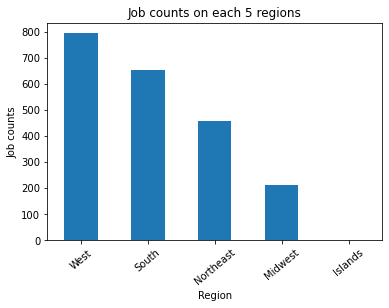

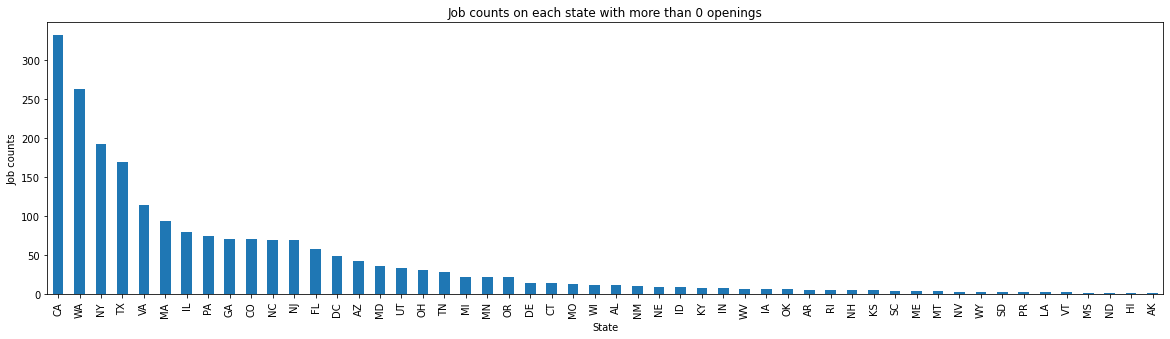

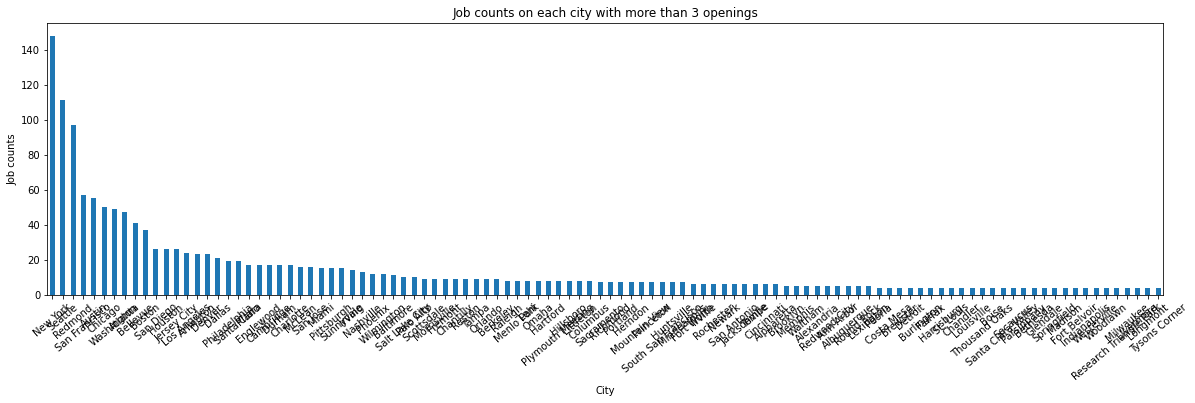

Princeton jobs:  7
count       232.000000
mean      84281.797414
std       45632.445543
min       22880.000000
25%       46800.000000
50%       75000.000000
75%      112990.000000
max      350000.000000
Name: SalaryMidValue, dtype: float64


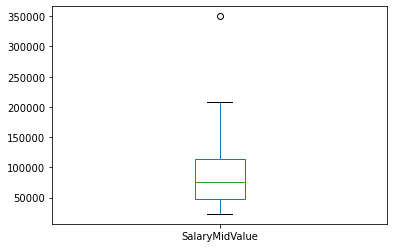

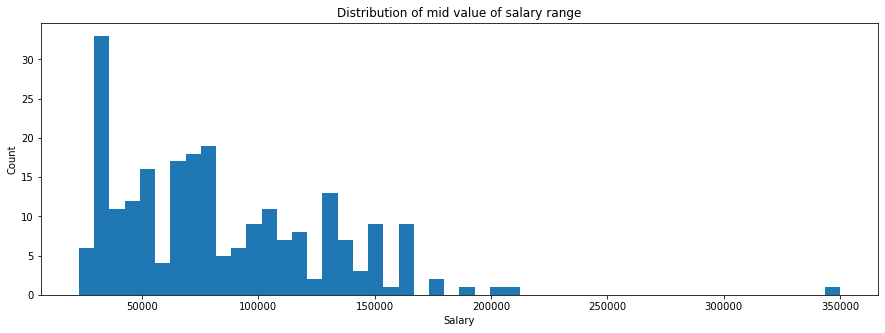

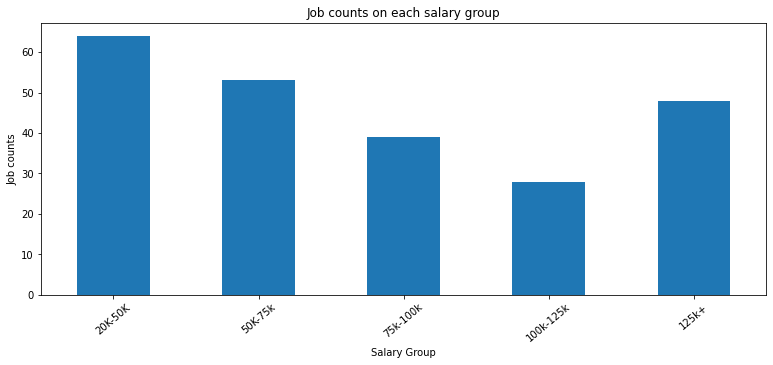

IndexError: index 0 is out of bounds for axis 0 with size 0

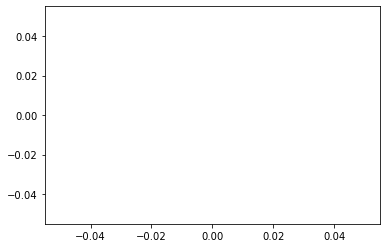

In [146]:
%load_ext autoreload
%autoreload 2

import pandas as pd
from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import pandas_profiling
from pandas_profiling.utils.cache import cache_file
import os
import sys

# Add project path
parent_project_path = os.path.abspath(os.path.join('..'))
if parent_project_path not in sys.path:
    sys.path.append(parent_project_path)
from src.library.sb_utils import save_file

#step 1: To combine 4 datasets into one dataframe
today = datetime.today().strftime('%Y_%m_%d')
dfNames=['da','ds','ml','ai']
data = pd.DataFrame()

for n in dfNames:
    fileName = '../data/raw/{0}_last{1}d_RC_{2}.csv'.format(n,'1', today)
    df = pd.read_csv(fileName, skiprows=[0])

    #combine 4 files together
    data = data.append(df, ignore_index=True)
    
#step 2: To de-dup the records in the combined datasets
print("Duplicated JobIDs: " + str(data.duplicated(subset ='JobID').sum()))
data.drop_duplicates(subset = 'JobID', inplace= True)
# To reindex 
data.index = np.arange(0,len(data))

#step 3: To create a new date variable 'DatePosted' by remove the string from 'PostDate' and convert to int
data['DatePosted'] = data.PostDate.str.replace('day ago|days ago','').str.replace('Today|Just posted','0').str.strip().astype(int)
# To convert 'ExtractDate' to datetime type
data['ExtractDate'] = pd.to_datetime(data['ExtractDate'])
# To Convert 'DatePosted' from int to timeDelta type and compute the exact date when the job was posted 
data.DatePosted = pd.to_timedelta(data.DatePosted, unit='D')
data.DatePosted = pd.to_datetime(data['ExtractDate'] - data['DatePosted'])

#step 4: To create a new boolean variable 'isRemote' and assign Ture if varible 'Remote' OR 'Location' is Remote
data['isRemote'] = (data.Remote == 'Remote') | (data.Location =='Remote')

#step 5: To create three new variables City, State and Region
newDf = data.Location.str.split(pat =',',expand =True)
data['City'] = newDf[0]
data['State'] = newDf[1]
# To clean up values of City
data.loc[data.City == 'Remote', 'City'] = np.nan
data.loc[data.City == 'United States', 'City'] = np.nan
# To fill the missing value of 'State' from 'City' for those which has only location of State 
data.State.fillna(data.City, inplace=True)
# To clean up values in 'City'
data.loc[data.State == data.City, 'City'] = np.nan
# To clean up the value of 'Washington DC' on variable 'City'
data.loc[(data.City == 'Washington') & (data.State == 'DC'), 'City'] ='DC'
us_state_abbrev = {'Alabama': 'AL','Alaska': 'AK','American Samoa': 'AS','Arizona': 'AZ','Arkansas': 'AR','California': 'CA','Colorado': 'CO','Connecticut': 'CT',
    'Delaware': 'DE','District of Columbia': 'DC','Florida': 'FL','Georgia': 'GA','Guam': 'GU',
    'Hawaii': 'HI', 'Idaho': 'ID','Illinois': 'IL', 'Indiana': 'IN','Iowa': 'IA', 'Kansas': 'KS','Kentucky': 'KY', 'Louisiana': 'LA',
    'Maine': 'ME','Maryland': 'MD','Massachusetts': 'MA','Michigan': 'MI','Minnesota': 'MN','Mississippi': 'MS','Missouri': 'MO','Montana': 'MT', 'Nebraska': 'NE',
    'Nevada': 'NV','New Hampshire': 'NH','New Jersey': 'NJ','New Mexico': 'NM','New York': 'NY','North Carolina': 'NC',
    'North Dakota': 'ND','Northern Mariana Islands':'MP','Ohio': 'OH', 'Oklahoma': 'OK','Oregon': 'OR', 'Pennsylvania': 'PA',
    'Puerto Rico': 'PR', 'Rhode Island': 'RI','South Carolina': 'SC','South Dakota': 'SD','Tennessee': 'TN',  'Texas': 'TX','Utah': 'UT',
    'Vermont': 'VT','Virgin Islands': 'VI','Virginia': 'VA','Washington': 'WA','West Virginia': 'WV','Wisconsin': 'WI', 'Wyoming': 'WY'
}
# To extract State abbrevation value from City variables to fill those missing values into 'State'
data.loc[data.State.str.len() >3,'State']=data.loc[data.State.str.len() >3,'State'].str.replace(' State','').map(us_state_abbrev)
# To clean up the State values
data.State= data.State.str.strip()

# To categorize state value into 4 regions 
us_state_regions = {'Alabama': 'South','Alaska': 'West','American Samoa': 'Islands',
    'Arizona': 'West','Arkansas': 'South','California': 'West','Colorado': 'West',
    'Connecticut': 'Northeast', 'Delaware': 'South','District of Columbia': 'South','Florida': 'South',
    'Georgia': 'South', 'Guam': 'Islands','Hawaii': 'West',  'Idaho': 'West',
    'Illinois': 'Midwest', 'Indiana': 'Midwest','Iowa': 'Midwest','Kansas': 'Midwest','Kentucky': 'South',
    'Louisiana': 'South','Maine': 'Northeast','Maryland': 'South', 'Massachusetts': 'Northeast',
    'Michigan': 'Midwest','Minnesota': 'Midwest','Mississippi': 'South','Missouri': 'Midwest',
    'Montana': 'West', 'Nebraska': 'Midwest','Nevada': 'West','New Hampshire': 'Northeast', 'New Jersey': 'Northeast',
    'New Mexico': 'West', 'New York': 'Northeast', 'North Carolina': 'South','North Dakota': 'Midwest', 'Northern Mariana Islands':'Islands',
    'Ohio': 'Midwest','Oklahoma': 'South', 'Oregon': 'West','Pennsylvania': 'Northeast','Puerto Rico': 'Islands',
    'Rhode Island': 'Northeast','South Carolina': 'South','South Dakota': 'Midwest','Tennessee': 'South',
    'Texas': 'South','Utah': 'West','Vermont': 'Northeast','Virgin Islands': 'Islands','Virginia': 'South',
    'Washington': 'West','West Virginia': 'South','Wisconsin': 'Midwest','Wyoming': 'West'}
# To create a new variable 'Region' by mapping to the dict
us_state_regions_mapping =  {v: us_state_regions[k] for k, v in us_state_abbrev.items()}
data['Region'] = data.loc[~data.State.isnull(),'State'].map(us_state_regions_mapping).astype('category')

data.Region.value_counts().plot(kind='bar')
plt.ylabel('Job counts')
plt.xlabel('Region')
plt.xticks(rotation=40)
plt.title('Job counts on each 5 regions')
plt.show()

plt.subplots(figsize=(20, 5))
data.State.value_counts().plot(kind='bar')
plt.ylabel('Job counts')
plt.xlabel('State')
plt.title('Job counts on each state with more than 0 openings')
plt.show()

plt.subplots(figsize=(20, 5))
data.groupby('City').filter(lambda x: len(x) >3 )['City'].value_counts().plot(kind='bar')
plt.xticks(rotation=40)
plt.ylabel('Job counts')
plt.xlabel('City')
plt.title('Job counts on each city with more than 3 openings')
plt.show()     

print("Princeton jobs: ",data.City.str.contains('Princeton').sum())

#step 6: To create new variables 'isSenior', 'isJunior','isMid'
data['isSenior'] = data.JobTitle.str.contains('Senior|Sr|sr|Director|VP|Lead|Principal')
data['isJunior'] = data.JobTitle.str.contains('Junior|Jr|jr|Intern')
data['isMid'] = data.JobTitle.str.contains('Mid Level|Mid-')

#step 7: To create new variables 'SalaryUnit', 'SalaryMidValue' and 'SalaryGroup'
# To create a new variable 'SalaryUnit'
data['SalaryUnit'] = data.Salary.str.extract('(an hour|a year|a month|a week|per class|a day)', expand = True)

# To create a new variable 'SalaryMidValue' going to contain the mid point value for the arrange of salary
# Set busniss rule to treat range: take mid value of a range and Ignore 'Up to' and 'From' 
data['SalaryMidValue'] = data.Salary.str.replace('[^0-9-.]','')

# Take mid value for range salary
s_df = data.SalaryMidValue.str.split(pat ='-',expand =True)
s_df[1].fillna(s_df[0], inplace=True)
data['SalaryMidValue']  = (s_df[1].astype(float)+s_df[0].astype(float))/2

# Convert hourly rate to Salary based on formula hr * 40 * 52 
data.loc[data.SalaryUnit.str.contains('hour', na=False),'SalaryMidValue'] = data.SalaryMidValue * 40 * 52
# Convert monthly rate to Salary based on formula mr * 12
data.loc[data.SalaryUnit.str.contains('month', na=False),'SalaryMidValue'] = data.SalaryMidValue * 12
# Convert weekly rate to Salary based on fomula wr * 52 
data.loc[data.SalaryUnit.str.contains('week', na = False), 'SalaryMidValue'] =data.SalaryMidValue * 52
# Convert daily rate to Salary based on formula dr * 5 * 52
data.loc[data.SalaryUnit.str.contains('day', na=False),'SalaryMidValue'] = data.SalaryMidValue * 5 * 52
# Ignore the teaching job
data.loc[data.SalaryUnit.str.contains('class', na=False),'SalaryMidValue'] = np.nan

print(data.SalaryMidValue.describe())
data.SalaryMidValue.plot(kind='box')
plt.show()

plt.subplots(figsize = (15,5))
data.SalaryMidValue.plot(kind='hist', bins=50)
plt.xlabel('Salary')
plt.ylabel('Count')
plt.title('Distribution of mid value of salary range')
plt.show()

# Create variable 'SalaryGroup'
salaryGroupLabels = ['20K-50K','50K-75k','75k-100k','100k-125k','125k+']
salaryRanges =[20000, 50000, 75000, 100000, 125000, np.inf]
data['SalaryGroup'] = pd.cut(data.SalaryMidValue, bins = salaryRanges, labels = salaryGroupLabels)

plt.subplots(figsize=(13,5))
data.SalaryGroup.value_counts(sort=False).plot(kind='bar')
plt.xticks(rotation =40)
plt.xlabel('Salary Group')
plt.ylabel('Job counts')
plt.title('Job counts on each salary group')
plt.show()

#step 8: To create a new variable 'CompanySizeGroup'
companySizeGroup_mapping={'1001 to 5,000':'Large', 'more than 10,000':'Large', '5,001 to 10,000':'Large','501 to 1,000':'Midsize','201 to 500':'Midsize', '51 to 200':'Small',  '11 to 50':'Small'}
data['CompanySizeGroup'] = data.loc[~data.CompanySize.isnull(), 'CompanySize'].map(companySizeGroup_mapping).astype('category')

data.CompanySizeGroup.value_counts().plot(kind='barh')
plt.xticks(rotation ='40')
plt.ylabel('Company Size')
plt.xlabel('Job counts')
plt.title('Job counts on size group of company')
plt.show()

plt.subplots(figsize=(13,5))
data.CompanyIndustry.value_counts().plot(kind='barh')
plt.xlabel('Job counts')
plt.ylabel('Industry')
plt.title('Job counts on each Industry')
plt.show()

#step 8: To create a profile and save to the reports folder
profile_report = data.profile_report(html={'style': {'full_width': True}})
profile_report.to_file("../reports/pandas_profiling/{0}_daily.html".format(today))

#step 9: Save the processed df into inter
# Drop few columns not needed for further analysis
s_data = data.drop(columns = ['PostDate','ExtractDate','Remote', 'JobUrl'])
# save the data to a new csv file
datapath = '../data/interim/'
fileName = '{0}_daily.csv'.format(today)
save_file(s_data, fileName, datapath)



In [8]:
data.loc[data.Company.str.contains('Microsoft')]

,JobID,JobTitle,Company,Location,CompanyRating,CompanyUrl,CompanyIndustry,CompanySize,PostDate,ExtractDate,...,isRemote,City,State,Region,isSenior,isJunior,isMid,SalaryUnit,SalaryMidValue,SalaryGroup
10,0147adfc5b7ee0ce,Senior Data Analyst,Microsoft,"Redmond, WA",4.2,https://www.indeed.com/cmp/Microsoft,Information Technology,"more than 10,000",Today,2021-02-28,...,False,Redmond,WA,West,True,False,False,NaN,NaN,NaN
92,b3593a18dd7d8ef6,Data and Applied Scientist 2,Microsoft,"Redmond, WA",4.2,https://www.indeed.com/cmp/Microsoft,Information Technology,"more than 10,000",Today,2021-02-28,...,False,Redmond,WA,West,False,False,False,NaN,NaN,NaN
97,b4e3ca4730508f82,Security Data Scientist,Microsoft,"Atlanta, GA",4.2,https://www.indeed.com/cmp/Microsoft,Information Technology,"more than 10,000",Today,2021-02-28,...,False,Atlanta,GA,South,False,False,False,NaN,NaN,NaN
114,d3675c978d129aac,Data Engineer II,Microsoft,"Redmond, WA",4.2,https://www.indeed.com/cmp/Microsoft,Information Technology,"more than 10,000",Today,2021-02-28,...,False,Redmond,WA,West,False,False,False,NaN,NaN,NaN
121,1889c31c28b2bcd0,Software Engineer,Microsoft,"Atlanta, GA",4.2,https://www.indeed.com/cmp/Microsoft,Information Technology,"more than 10,000",Today,2021-02-28,...,False,Atlanta,GA,South,False,False,False,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
814,1d7286a2aaa35bd7,"Principal Program Manager, OCTO Partner Engage...",Microsoft,"Redmond, WA",4.2,https://www.indeed.com/cmp/Microsoft,Information Technology,"more than 10,000",Today,2021-02-28,...,False,Redmond,WA,West,True,False,False,NaN,NaN,NaN
816,1a82525f6ca6c51c,Principal Content Design Manager,Microsoft,"Redmond, WA",4.2,https://www.indeed.com/cmp/Microsoft,Information Technology,"more than 10,000",Today,2021-02-28,...,False,Redmond,WA,West,True,False,False,NaN,NaN,NaN
820,bf400f9b06bb2863,Principal Data & Applied Scientist Manager,Microsoft,"Redmond, WA",4.2,https://www.indeed.com/cmp/Microsoft,Information Technology,"more than 10,000",Today,2021-02-28,...,False,Redmond,WA,West,True,False,False,NaN,NaN,NaN
822,784eac36ff65454c,Senior Program Manager,Microsoft,"Redmond, WA",4.2,https://www.indeed.com/cmp/Microsoft,Information Technology,"more than 10,000",Today,2021-02-28,...,False,Redmond,WA,West,True,False,False,NaN,NaN,NaN
